<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/0530_HW_TimeSeries2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **시계열 분석 (2)**

# **LSTM**

LSTM : 확장된 RNN 방식
- RNN은 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에 기울기 소멸 문제가 발생함
- LSTM, GRU 와 같은 확장된 RNN 방식을 사용하여 문제를 해결

## **LSTM 구조**

### **LSTM 순전파**

기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가

**1. 망각 게이트(forget gate)**

과거 정보를 어느 정도 기억할지 결정하는 게이트
- 과거 정보와 현재 데이터를 입력받아 시그모이드를 취한 후, 그 값을 과거 정보에 곱함
- 시그모이드의 출력 값에 따른 결과
    - 0 : 과거 정보를 버린다
    - 1 : 과거 정보를 온전히 보존한다



[망각 게이트의 수식]

$ f_t = \sigma(w_f[h_{t-1}, x_t])$

$ c_t = f_t \cdot c_{t-1} $

![forget gate](https://thebook.io/img/080289/394.jpg)

- 0~1 사이의 출력 값을 가지는 $h_{t-1}$과 $x_t$를 입력 값으로 받음
    - 이 두 값을 이용하여 이전 상태 정보를 현재 메모리에 반영할지 결정함
    - 1 : 직전 정보를 메모리에 유지
    - 0 : 초기화
- $x_t$ : 새로운 입력 값
- $h_{t-1}$ : 이전 은닉층에서 입력되는 값

**2. 입력 게이트(input gate)**

현재 정보를 기억하기 위해 만들어진 게이트
- 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량을 결정
- 즉, 현재 메모리에 새로운 정보를 반영할지 결정하는 역할
- 계산 값에 따른 결과
    - 1 : 입력 $x_t$가 들어올 수 있도록 허용(open)
    - 0 : 차단

[입력 게이트의 수식]

$ i_t = \sigma(w_i[h_{t-1}, x_t])$

$ \tilde c_t = tanh(w_c[h_{t-1}, x_t])$

$ c_t = c_{t-1} + i_t \cdot \tilde c_t$

![input gate](https://thebook.io/img/080289/395.jpg)

**3. 셀(cell)**

각 단계에 대한 은닉 노드(hidden node)를 메모리 셀이라고 함
- '총합(sum)'을 사용하여 셀 값을 반영하며, 이를 통해 기울기 소멸 문제를 해결

셀을 업데이트 하는 방법

: 망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태(cell state)를 업데이트함


[셀에 대한 수식]

$ f_t = \sigma(w_f[h_{t-1}, x_t])$

$ c_t = c_{t-1} + i_t \cdot \tilde c_t $

![cell](https://thebook.io/img/080289/396.jpg)

**4. 출력 게이트(output gate)**

과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정
- 이전 은닉 상태(hidden state)와 t번째 입력을 고려하여 다음 은닉 상태를 계산함
- 이 은닉 상태가 그 시점에서의 출력이 됨
- 계산한 값에 따른 결과
    - 1 : 의미 있는 결과로 최종 출력
    - 0 : 해당 연산 출력을 하지 않음

[출력 게이트의 수식]

$ o_t = \sigma(w_o[t_{t-1}, x_t])$

$ h_t = o_t \cdot tanh(c_{t-1})$

![output_gate](https://thebook.io/img/080289/397_1.jpg)

**LSTM 전체 게이트 도식화**

![TOTAL GATE](https://thebook.io/img/080289/397_2.jpg)

### **LSTM 역전파**

LSTM 은 셀을 통해서 역전파를 수행하기 때문에 '중단 없는 기울기(uniterrupted gradient flow)'라고도 함

최종 오차는 모든 노드에 전파되는데, 이때 셀을 통해서 중단 없이 전파됨

![lstm_역전파](https://thebook.io/img/080289/398_1.jpg)

[역전파 수행 공식]

![formula](https://thebook.io/img/080289/fn2-58.jpg)

## **LSTM 셀 구현**

MNIST 데이터를 활용하여 LSTM 셀과 LSTM 계층 살펴보기

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter  # 파라미터 목록을 가지고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [ ]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (1.0, )) # 평균 0.5, 표준편차 1.0으로 정규화
])

In [ ]:
# 데이터셋 내려받기
# torchvision.datasets에서 제공하는 데이터셋 중 MNIST 사용

from torchvision.datasets import MNIST

download_root = '../chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)

valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.86MB/s]


코드 설명

1. `download_root` : MNIST 데이터셋을 내려받을 위치 지정
2. `transform` : 앞에서 정의한 데이터 전처리 적용
3. `train` : True의 경우 훈련용 데이터셋을 가져오며, False로 설정할 경우 테스트용 데이터셋을 가져옴
4. `download` : True의 경우 내려받으려는 위치에 MNIST 파일이 없으면 내려받지만 파일이 있다면 내려받지 않음



In [ ]:
# 내려받은 MNIST 파일을 메모리로 불러옴 (DataLoader 이용)
# 주의 : 데이터로더 객체가 "호출될 때" 메모리로 불러옴!

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)

In [ ]:
# 변수 값 지정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
# LSTM 셀 네트워크 구축

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy, cy)

`self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)` 에서 은닉층의 뉴런/유닛에 4를 곱하는 이유?

: `gates`가 네 개로 쪼개지는 상황이기 때문
- `ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)` 에서 게이트가 쪼개져서 각각 망각, 입력, 셀, 출력 게이트를 의미하는 변수에 저장됨

In [ ]:
# LSTM 셀의 전반적 네트워크

class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]

       for seq in range(x.size(1)) : #LSTM 겔 계층 반복해 쌓음
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)

       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

LSTM 셀 : 앞에서 정의한 함수를 불러오는 부분

[파라미터]

`self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)`
- input_dim : 입력에 대한 특성 수 (칼럼 개수)
- hidde_dim : 은닉층의 뉴런 개수
- layer_dim : 은닉층의 계층 개수

In [ ]:
# 옵티마이저와 손실 함수 지정

input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습 및 성능 확인 (성능 확인 : 검증 데이터셋으로)
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.237457513809204. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 0.8865489363670349. Accuracy: 75.66000366210938
Iteration: 1500. Loss: 0.36925092339515686. Accuracy: 89.68000030517578
Iteration: 2000. Loss: 0.22741778194904327. Accuracy: 93.22000122070312
Iteration: 2500. Loss: 0.04691021144390106. Accuracy: 95.62999725341797
Iteration: 3000. Loss: 0.05541188269853592. Accuracy: 95.95999908447266
Iteration: 3500. Loss: 0.08951079845428467. Accuracy: 96.51000213623047
Iteration: 4000. Loss: 0.02204427309334278. Accuracy: 96.95999908447266
Iteration: 4500. Loss: 0.07599193602800369. Accuracy: 96.76000213623047
Iteration: 5000. Loss: 0.05491260439157486. Accuracy: 97.11000061035156
Iteration: 5500. Loss: 0.16436734795570374. Accuracy: 96.5199966430664
Iteration: 6000. Loss: 0.01572381891310215. Accuracy: 97.20999908447266
Iteration: 6500. Loss: 0.01401564758270979. Accuracy: 97.88999938964844
Iteration: 7000. Loss: 0.01943875104188919. Accuracy: 97.91999816894

In [ ]:
# 테스트 데이터셋을 이용한 모델 예측 성능 확인

def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [ ]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


사전에 전처리가 되지 않은 데이터셋의 경우, 정확도를 높이기 위해 은닉층의 개수(혹은 뉴런의 개수) 및 하이퍼파라미터 수정 등이 필요

## **LSTM 계층 구현**

스타벅스 주가 데이터셋 활용, 얼마나 주가 예측을 잘 하는지 !

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/25-1 OB/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

In [ ]:
# 훈련과 레이블 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [ ]:
# 데이터 분포 조정
ms = MinMaxScaler()  # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler()   # 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [ ]:
# 데이터셋의 형태 및 크기 조정

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
# LSTM 네트워크
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
# 변수 값 설정
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.18287
Epoch : 100, loss : 0.01743
Epoch : 200, loss : 0.01511
Epoch : 300, loss : 0.01205
Epoch : 400, loss : 0.01163
Epoch : 500, loss : 0.01164
Epoch : 600, loss : 0.01157
Epoch : 700, loss : 0.01150
Epoch : 800, loss : 0.01199
Epoch : 900, loss : 0.01047


In [ ]:
# 모델 예측 결과 출력을 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

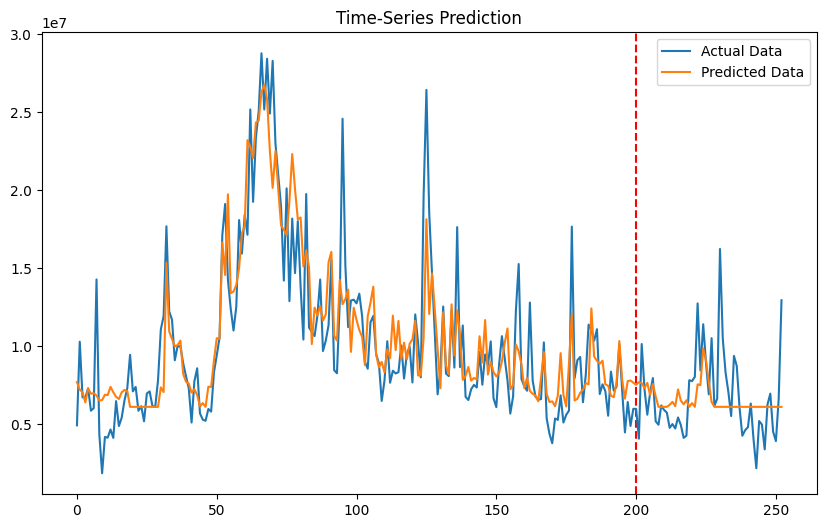

In [ ]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()